In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


<AxesSubplot:>

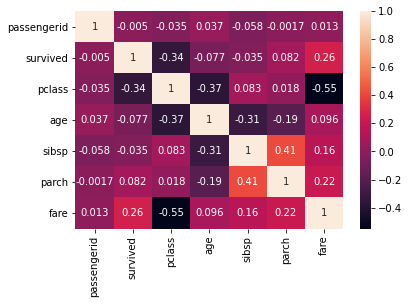

In [2]:
#correlation for numerical columns
df = pd.read_csv("/kaggle/input/titanic/train.csv")
df.columns= df.columns.str.lower()
sns.heatmap(df.corr(), annot=True)

In [3]:
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

In [4]:
df.dtypes

passengerid      int64
survived         int64
pclass           int64
name            object
sex             object
age            float64
sibsp            int64
parch            int64
ticket          object
fare           float64
cabin           object
embarked        object
dtype: object

In [5]:
df=df.drop(['name','cabin','ticket'], axis = 1)

In [6]:
target_column="survived"
X = df.loc[:,df.columns != target_column]
y = df[target_column]
# X_train.head()
#y_train_head()
# X_train.describe()

In [7]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb



np.random.seed(0)

In [8]:
#-------------------------------------
# Load data from https://www.openml.org/d/40945
#X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

In [9]:
numeric_features = ["passengerid","age", "fare"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())
          ]
)

categorical_features = ["embarked","sex", "pclass"]
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
         ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.

In [10]:
# For HTML representation of pipelines
from sklearn import set_config

set_config(display="diagram")

clf = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", LogisticRegression())]
    )
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['passengerid', 'age',
                                                   'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'sex',
                                                   'pclass'])])),
                ('classifier', LogisticRegression())])

In [11]:
def clf_models(modelname):
    clf = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", modelname)]
    )
    return clf

In [12]:
models_list=[
    LogisticRegression(),
  #  Lasso(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    lgb.LGBMClassifier(),
    LinearSVC(random_state=42, C=0.01),
    #xgb.XGBRegressor(objective="reg:linear", random_state=42)   
    xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.1), 
    xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.05), #better. 
    xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.01), 
    #  "multi:softprob"
]

In [13]:
# for model in models_list:
#     clf=clf_models(model)
#     clf.fit(X_train, y_train)
#     print(model)
#     print("model score: %.3f" % clf.score(X_test, y_test))

# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
# https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.head()

,passengerid,pclass,sex,age,sibsp,parch,fare,embarked
140,141,3,female,NaN,0,2,15.2458,C
439,440,2,male,31.0,0,0,10.5000,S
817,818,2,male,31.0,1,1,37.0042,C
378,379,3,male,20.0,0,0,4.0125,C
491,492,3,male,21.0,0,0,7.2500,S


In [15]:
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
import warnings
warnings.filterwarnings('ignore')

l=[]
for model in models_list:
    clf=clf_models(model)
    print(model)
    fit_model=clf.fit(X_train, y_train)
    score=clf.score(X_test, y_test)
    print("model score: %.3f" % score)
    l.append([model, clf, score])
    #scores = -1 * cross_val_score(clf, X, y,cv=5,scoring='neg_mean_absolute_error')
    #print("MAE scores:\n", scores.mean(), scores.sum(), scores.min())
    
#print(l)

LogisticRegression()
model score: 0.799
RandomForestClassifier()
model score: 0.832
GradientBoostingClassifier()
model score: 0.832
LGBMClassifier()
model score: 0.860
LinearSVC(C=0.01, random_state=42)
model score: 0.782
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, eval_metric='auc',
              gamma=None, gpu_id=None, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1,
              max_delta_step=None, max_depth=6, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=0,
              reg_alpha=None, reg_lambda=None, scale_pos_weight=None,
              subsample=None, tree_method=None, validate_parameters=None,
              verbosity=None)
model score: 0.855
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=N

In [16]:
x_test = pd.read_csv("/kaggle/input/titanic/test.csv")
x_test.columns= x_test.columns.str.lower()
x_test=x_test.drop(['name','cabin','ticket'], axis = 1)
x_test.head()
# final_model=xgb.XGBClassifier(objective="binary:logistic", random_state=0, eval_metric="auc", n_estimators=100, max_depth=6,learning_rate=0.05)
# clf=clf_models(final_model)
# print(model)
# clf.fit(X_train, y_train)
# score=clf.score(X_test, y_test)
# print("model score: %.3f" % score)
predictions=l[6][1].predict(x_test)
predictions[:5]

array([0, 0, 0, 0, 1])

In [17]:
x_test.head()

,passengerid,pclass,sex,age,sibsp,parch,fare,embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [18]:
# note: 'lower' of column names.
output=pd.DataFrame({"PassengerId": x_test.passengerid, "Survived":predictions})
output.to_csv("submission.csv", index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
